## Import Libraries

In [137]:
# pip install python-dotenv (for storing API key)
# In terminal, run export POLYGON_API_KEY='your_api_key'

import pandas as pd
import requests
from dotenv import load_dotenv
import os
from datetime import datetime, timedelta
import plotly.express as px

## Call Polygon API
- Define API key, timeframe, ticker, limit
- See section on 'Ticker News' for more details (https://polygon.io/docs/stocks/get_v2_reference_news)

In [138]:
api_key = os.getenv('POLYGON_API_KEY')
ticker = 'TSLA'

In [139]:
today = datetime.now()
last_week = today - timedelta(days=7)

# Format dates for the API
start_date = last_week.strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')

limit = '100' #num news sources you want

api_url = f'https://api.polygon.io/v2/reference/news?ticker={ticker}&published_utc.gte={start_date}&published_utc.lte={end_date}&order=desc&limit={limit}&apiKey={api_key}'


In [140]:
data = requests.get(api_url).json()

In [141]:
data['results'][0].keys()

dict_keys(['id', 'publisher', 'title', 'author', 'published_utc', 'article_url', 'tickers', 'image_url', 'description', 'keywords', 'insights'])

## Data Cleaning
- Transform relevant JSON data to DataFrame
- Clean DF

In [142]:
news_lst = []
published_date_lst = []
sentiment_lst = []
sentiment_reason_lst = []

# Loop through each news article in the results
for news_blurb in data['results']:
    
    # Capture news desc
    desc = news_blurb.get('description', 'No description available')
    news_lst.append(desc)
    
    # Capture publish date
    published_date = news_blurb.get('published_utc', 'No published date')
    published_date_lst.append(published_date)
    
    # Capture sentiment label and reason
    insights = news_blurb.get('insights', [])
    sentiment_label = None
    sentiment_reason = None
    
    # Filter for the specified ticker (there are some news sources not relating to specified ticker that we need to filter out)
    for insight in insights:
        if insight['ticker'] == ticker:
            sentiment_label = insight.get('sentiment', 'No sentiment')
            sentiment_reason = insight.get('sentiment_reasoning', 'No reasoning provided')
            break  # Stop searching once we find the ticker

    # Append sentiment and reasoning, or default to None
    sentiment_lst.append(sentiment_label)
    sentiment_reason_lst.append(sentiment_reason)

df = pd.DataFrame({
    'Published Date': published_date_lst,
    'News': news_lst,
    'Sentiment': sentiment_lst,
    'Sentiment Reasoning': sentiment_reason_lst
})


In [143]:
df['Published Date'] = pd.to_datetime(df['Published Date'], format='%Y-%m-%dT%H:%M:%SZ')
df['Date'] = df['Published Date'].dt.normalize()
df['Sentiment'] = df['Sentiment'].apply(lambda x: -1 if x == 'negative' else 0 if x == 'neutral' else 1 if x == 'positive' else '')

In [145]:
# Agg avg sentiment over time
sentiment_over_time = df.groupby('Date')['Sentiment'].mean().reset_index()
sentiment_over_time.columns = ['Date', 'Avg Sentiment']


## EDA

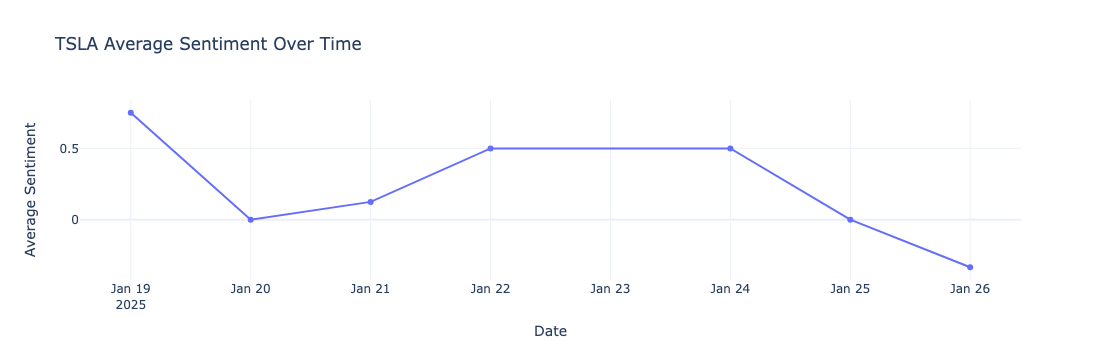

In [146]:
fig = px.line(sentiment_over_time, x='Date', y='Avg Sentiment',
              title=f'{ticker} Average Sentiment Over Time',
              labels={'Date': 'Date', 'Avg Sentiment': 'Average Sentiment'},
              markers=True)

# Update layout for better visuals
fig.update_layout(xaxis_title='Date',
                  yaxis_title='Average Sentiment',
                  template='plotly_white')

# Show the plot
fig.show()